In [45]:

import math
import numpy as np
%pip install matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


In [107]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None # does nothing by default (true for a leaf node)
        self._prev = set(_children)
        self._op = _op
        self.label = label 

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad = 1.0 * out.grad   # This is doing the chain rule to go backwards (remember this is called during '+' only)
            other.grad = 1.0 * out.grad
            
        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad = other.data * out.grad # This is doing the chain rule to go backwards (remember this is called during '*' only)
            other.grad = self.data * out.grad
        
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad # chained through local gradient

        out._backward = _backward        
        return out

a= Value(2.0, label='a')
b = Value(-3.0, label='b')
c= Value(10.0, label = 'c')
e = a * b; e.label = 'e'
d= e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [108]:
%pip install graphviz
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

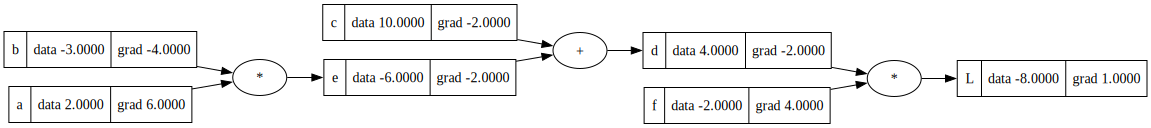

In [109]:
a.grad = 6.0
b.grad = -4.0
c.grad = -2.0
e.grad = -2.0
d.grad = -2.0
f.grad = 4.0
L.grad = 1.0
draw_dot(L)

In [110]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


In [111]:
def func():

    h = 0.001
    
    a= Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c= Value(10.0, label = 'c')
    e = a * b; e.label = 'e'
    d= e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a= Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c= Value(10.0, label = 'c')
    c.data += h
    e = a * b; e.label = 'e'
    d= e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2-L1)/h)

func()

-1.9999999999988916


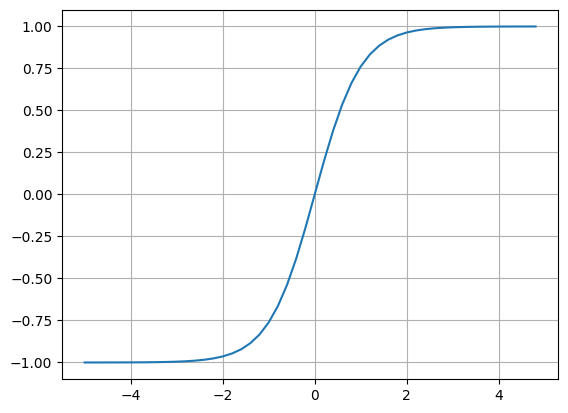

In [112]:
# example two, backprop through a neuron

plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [113]:
# inputs x1, x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights w1, w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
# bias of the neuron
b = Value(6.8813735870195432, label = 'b')

# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1';
x2w2 = x2*w2; x2w2.label = 'x2*w2';
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2';
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'output' # tan h is a squashing function that moves values between -1 and 1 (kinda)

In [114]:
o.grad = 1.0

In [115]:
# output (o) = tanh(n)
# do/dn = 1 - tanh(n) **2
# do/dn = 1 - o ** 2
# reminder: n.grad = derivative of d(output)/d(n) or do/dn
# n.grad = 1 - o ** 2 = .49999~
n.grad = 0.5

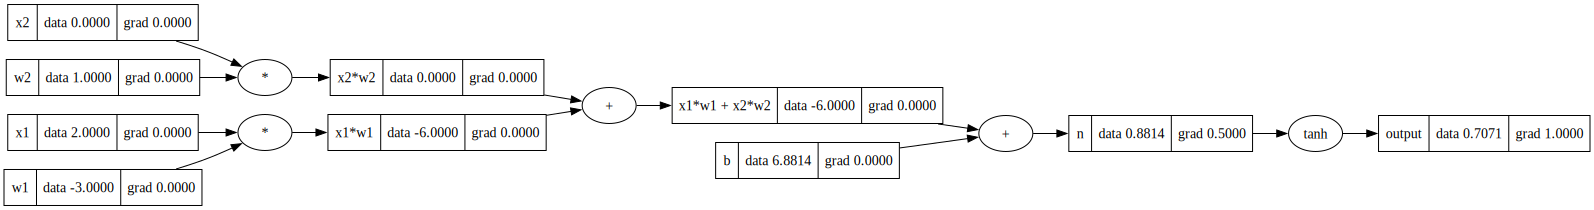

In [116]:
draw_dot(o)

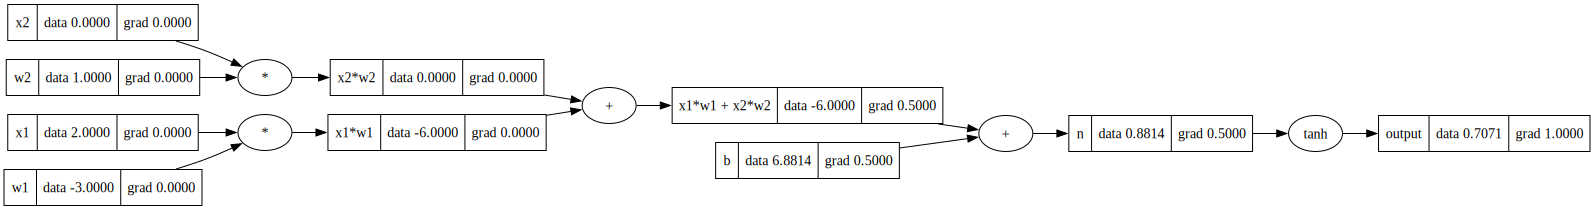

In [117]:
# grad carries through the '+' node, so the grad of the b and w1x1+w2x2 is both the same as n.grad
x1w1x2w2.grad = 0.5
b.grad = 0.5
draw_dot(o)

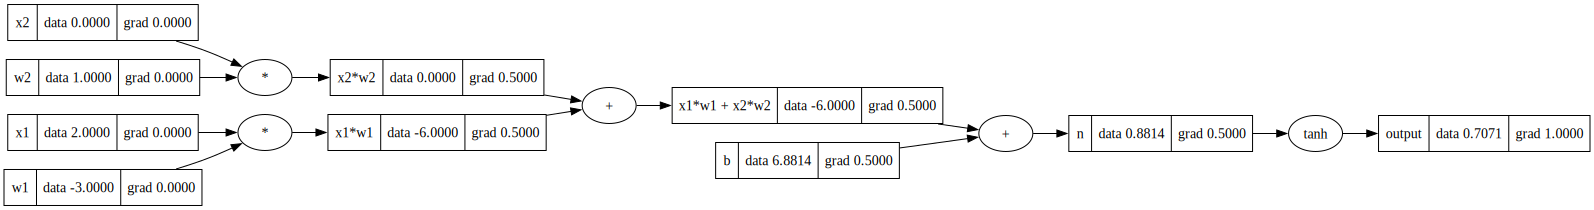

In [118]:
# grad again carried to x1w1 and x2w2
x1w1.grad = 0.5
x2w2.grad = 0.5
draw_dot(o)

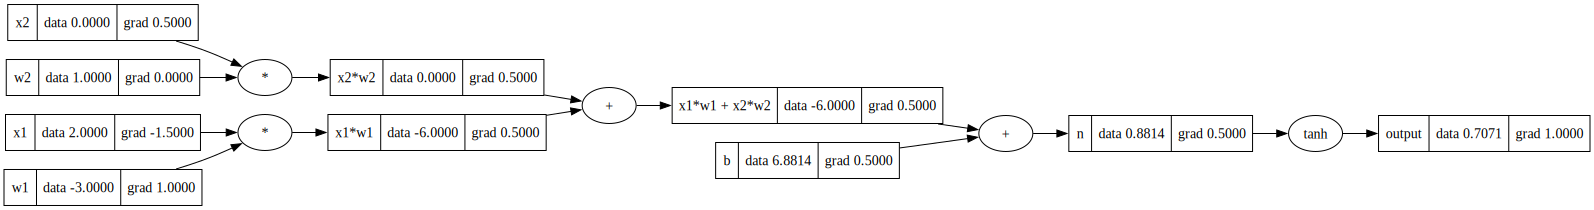

In [119]:
# through derivative proof, finding node.grad for a '*' just means multiplying the resultant grad by the other term data
x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data

x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data

draw_dot(o)

In [120]:
# from this, the following is true:
# # w2 grad is 0 means changing w2 has no impact on the final answer (which makes sense because its being multiplied by x2.data which is zero)
# # x2 grad is not 0 because changing it will actually have an impact on the output

# a positive gradient value means that if the .data goes up, then the output will go up

In [121]:
# now, we will use the 'backward' part of the Value class to do the backwards pass easier


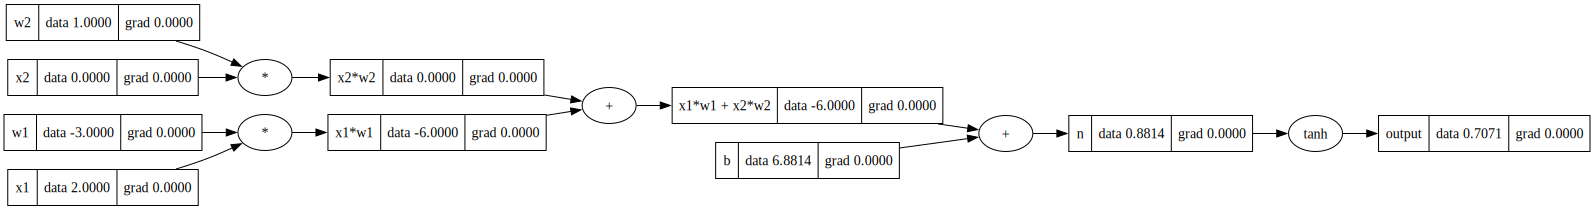

In [122]:
# reset the graph
# inputs x1, x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights w1, w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
# bias of the neuron
b = Value(6.8813735870195432, label = 'b')

# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1';
x2w2 = x2*w2; x2w2.label = 'x2*w2';
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2';
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'output'
draw_dot(o)

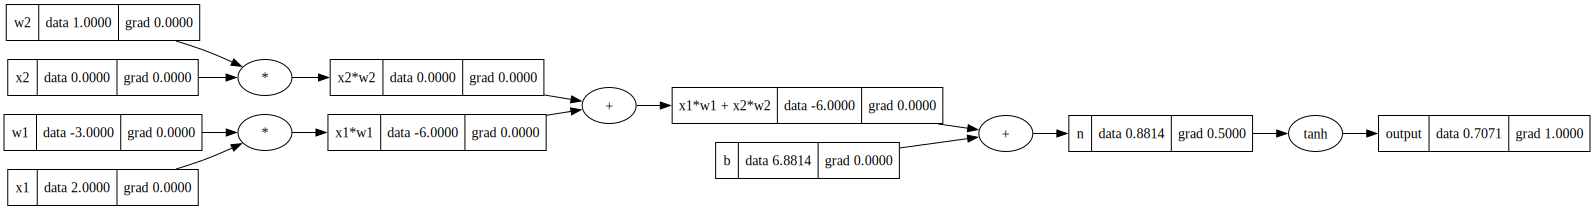

In [124]:
o.grad = 1.0 # default because deriviative of output with respect to output is just 1
o._backward() # this will call the backwards function through Tanh (because going backwards to n goes through tanh)
draw_dot(o) # so now 'n' will have a grad value

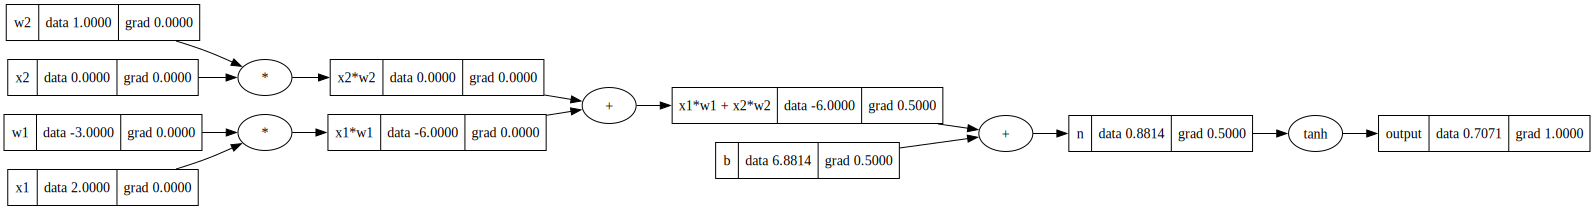

In [126]:
n._backward() # this will now call the backwards func through its prev nodes using the '+' version of backward
draw_dot(o) # so now 'x1*w1 + x2*w2' and 'b' should have grad values (the same as n in this case bc its +)

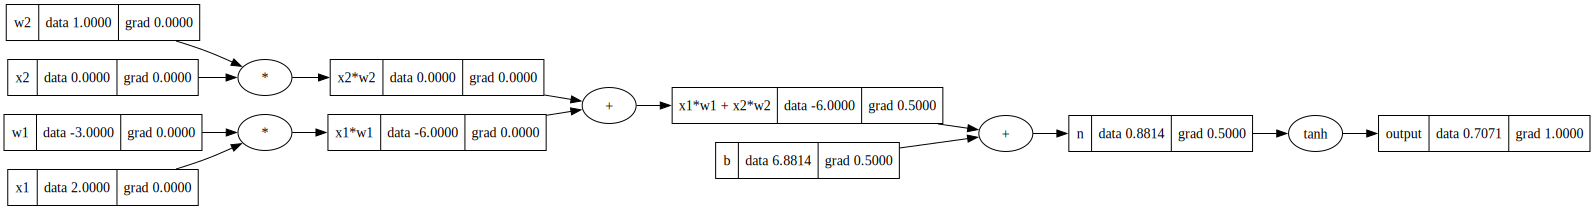

In [128]:
b._backward() #if we try to call backward on a leaf node...
draw_dot(o) # it will change nothing (bc its None by default)

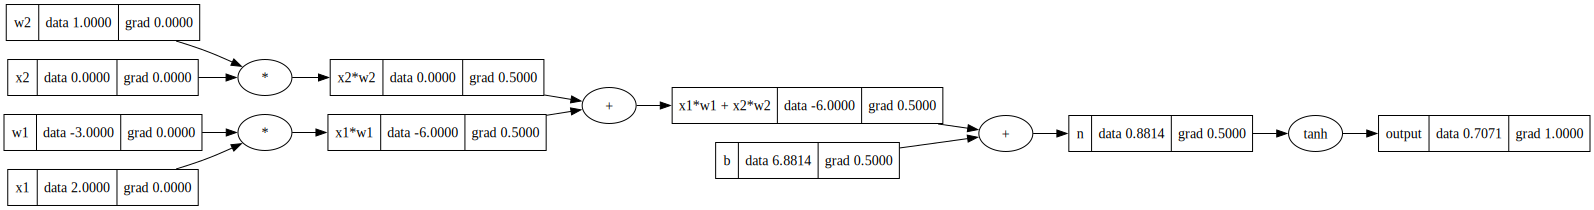

In [129]:
x1w1x2w2._backward() # this will now call the backwards func through its prev nodes using the '+' version of backward
draw_dot(o) # so now 'x2*w2' and 'x1*w1' should have grad values (the same as 'x1*w1 + x2w2' in this case bc its +)

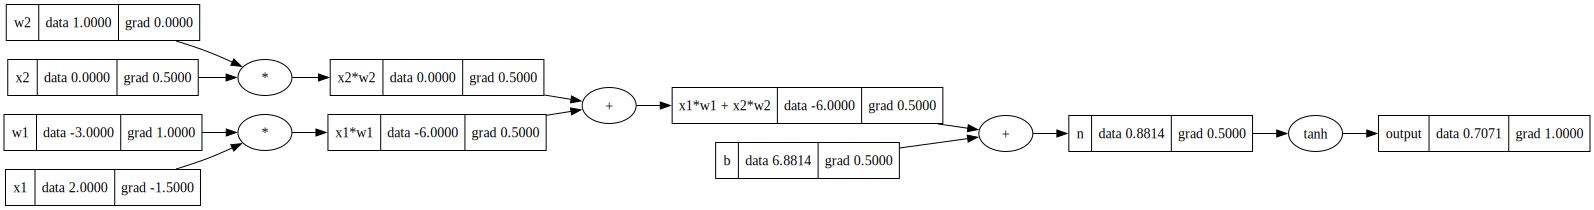

In [131]:
x2w2._backward()
x1w1._backward() # this calls the backward function now using the '*' version of the chain rule (which is w1.grad = other.data * out.grad or in this case w1.grad = 2 * .5 = 1)
draw_dot(o)